In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
from fastai.text.all import *
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = Path("/data/wr153")

pretrained_weights = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights, add_prefix_space=True)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

df_train = pd.read_csv(DATA_PATH.joinpath("text", "train.csv"), header=0)
df_valid = pd.read_csv(DATA_PATH.joinpath("text", "test.csv"), header=0)

all_texts = np.concatenate([df_train.to_numpy(), df_valid.to_numpy()], axis=0)


class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def encodes(self, x):
        toks = self.tokenizer.tokenize(x, is_split_into_words=True)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))

    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))


splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(
    all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader
)

bs, sl = 4, 512
dls = tls.dataloaders(bs=bs, seq_len=sl)


class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]


In [3]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [4]:
learn.freeze()

SuggestedLRs(valley=0.00010964782268274575)

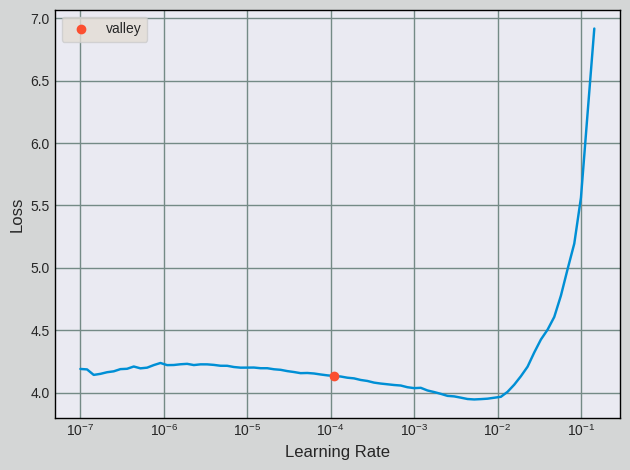

In [5]:
learn.lr_find()

In [6]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.092751,3.865761,47.739590,00:07
1,3.939909,3.735955,41.928059,00:07
2,3.768780,3.699278,40.418106,00:07
3,3.599486,3.708322,40.785305,00:07
4,3.439677,3.733363,41.819527,00:07
5,3.288484,3.765416,43.181671,00:07
6,3.154891,3.791306,44.314247,00:07
7,3.049541,3.816195,45.431026,00:07
8,2.968006,3.822004,45.695705,00:07
9,2.909748,3.822670,45.726135,00:07


In [7]:
prompt = "I remember my initiation"

In [8]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()

In [9]:
# https://huggingface.co/blog/how-to-generate
preds = learn.model.generate(
    inp,
    do_sample=True,
    max_length=200,
    top_k=50, 
    top_p=0.95,
    pad_token_id=tokenizer.eos_token_id,
)
tokenizer.decode(preds[0].cpu().numpy())


" I remember my initiation. it was at the end of the committee session of a country where every crime was a slap on the wrist. it was even more gratifying to see that one could draw a human face, rather than a hair cut, and that even though we were forbidden from wearing our veils, the young woman who dared to look at us had her own mark. in a way, it was very easy to recognize them. if they had been wearing veil irons, i don't believe they would have made any difference. my parents were shocked. so, what did they think of me? i'm the prophet! the rest is history. i'm my own teacher! you're right. i'm not a prophet! in any case, my mother was right. after that, it became a real routine, where we went for a bath together. she told me that he had been talking to me one day and that i needed to explain things quickly. i was ready to go"

In [10]:
torch.save(learn.state_dict(), "models/gpt2.pt")

In [11]:
learn.load_state_dict(torch.load("models/gpt2.pt"))
learn.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
preds = learn.model.generate(
    inp,
    do_sample=True,
    max_length=200,
    top_k=50, 
    top_p=0.95,
    pad_token_id=tokenizer.eos_token_id,
)
tokenizer.decode(preds[0].cpu().numpy())

' I remember my initiation. the room was absolutely beautiful. i was twenty feet from the counter. it was magnificent. the counter had a nice decorative design. a huge desk with a long log with the words "1.000 candied oranges." on it was written: "don\'t forget to pick up a bag of candied oranges, i promise you. it\'s the juiciest thing you\'ve ever tasted. thanks, everyone." in case anyone hadn\'t already heard this sentence: "a lot of fruit is better than nothing," or, "a lot of rice is better than nothing." it was well-known that people in austria were very picky, and we often found ourselves caught up in our own machinations. so we began to educate ourselves. so much so, that we began to think about the origins of education. in the course of a year, i read a great many volumes by the great scholars of the twenty-first century. my mother thought that her father'